# Modeling 4
* Scale numerical features.
* Aggregate `transcript_id`, `transcript_position`, `nucleotides` using mean.
* Seperate `nucleotides` and use as features.
* Use `transcript_position` as features.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import xgboost as xgb

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import \
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import \
    StratifiedKFold, GridSearchCV
from sklearn.metrics import \
    accuracy_score, precision_score, recall_score, f1_score, \
    roc_curve, precision_recall_curve, \
    roc_auc_score, average_precision_score, \
    confusion_matrix, classification_report
from xgboost import XGBClassifier 
from math import floor

%matplotlib inline
plt.style.use('default')
warnings.filterwarnings("ignore")

DATA_DIR = "../data"  # save data locally for faster read / write
MODEL_DIR = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/tanyeejet/models') # models' size not as big as data, save in s3 for everyone 

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, "df3_scaled.csv"))

In [3]:
df.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,7,8,gene_id,label
0,ENST00000000233,244,AAGACCA,0.011239,0.009548,0.649123,0.117647,0.050283,0.578164,0.075390,0.058543,0.281707,ENSG00000004059,0
1,ENST00000000233,244,AAGACCA,0.039294,0.011831,0.649123,0.049729,0.022461,0.627792,0.085258,0.033525,0.242683,ENSG00000004059,0
2,ENST00000000233,244,AAGACCA,0.025266,0.018581,0.448622,0.087575,0.058051,0.602978,0.032761,0.010845,0.226829,ENSG00000004059,0
3,ENST00000000233,244,AAGACCA,0.019605,0.009548,0.649123,0.048702,0.024112,0.677419,0.032761,0.019819,0.236585,ENSG00000004059,0
4,ENST00000000233,244,AAGACCA,0.042082,0.013725,0.586466,0.007335,0.018917,0.665012,0.111901,0.038148,0.258537,ENSG00000004059,0


In [4]:
df.dtypes

transcript_id           object
transcript_position      int64
nucleotides             object
0                      float64
1                      float64
2                      float64
3                      float64
4                      float64
5                      float64
6                      float64
7                      float64
8                      float64
gene_id                 object
label                    int64
dtype: object

In [5]:
df = df.astype({'transcript_position': 'str'})

In [6]:
# designate data types
# df['label'] = df['label'].astype(str)
# df['transcript_position'] = df['transcript_position'].astype(str)

In [7]:
df.dtypes

transcript_id           object
transcript_position     object
nucleotides             object
0                      float64
1                      float64
2                      float64
3                      float64
4                      float64
5                      float64
6                      float64
7                      float64
8                      float64
gene_id                 object
label                    int64
dtype: object

In [8]:
# groupby and agg using mean 
df2 = df.groupby(by = ['transcript_id', 'transcript_position', 'nucleotides']).mean()
df2.reset_index(inplace=True)
df2.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,7,8,label
0,ENST00000000233,244,AAGACCA,0.055809,0.020057,0.632866,0.056574,0.035630,0.626719,0.056097,0.023120,0.238662,0.0
1,ENST00000000233,261,CAAACTG,0.041822,0.015164,0.457160,0.037795,0.015452,0.403096,0.059703,0.015667,0.405984,0.0
2,ENST00000000233,316,GAAACAG,0.049941,0.013824,0.404457,0.042214,0.017473,0.292147,0.058172,0.010612,0.345906,0.0
3,ENST00000000233,332,AGAACAT,0.075716,0.030996,0.703697,0.051139,0.013863,0.278368,0.043828,0.011424,0.343341,0.0
4,ENST00000000233,368,AGGACAA,0.076394,0.030699,0.560454,0.072020,0.028289,0.577600,0.082485,0.022431,0.294863,0.0


In [9]:
df2.shape

(121838, 13)

In [10]:
# seperate nucleotides
tmp = df2['nucleotides'].str.split(pat="", expand=True)
tmp.drop(columns=[tmp.columns[0], tmp.columns[-1]], inplace=True)
tmp = tmp.add_prefix("p")
tmp = pd.get_dummies(tmp)
df3 = pd.concat([df2, tmp], axis=1)

In [11]:
df3.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,...,p3_G,p4_A,p5_C,p6_A,p6_C,p6_T,p7_A,p7_C,p7_G,p7_T
0,ENST00000000233,244,AAGACCA,0.055809,0.020057,0.632866,0.056574,0.035630,0.626719,0.056097,...,1,1,1,0,1,0,1,0,0,0
1,ENST00000000233,261,CAAACTG,0.041822,0.015164,0.457160,0.037795,0.015452,0.403096,0.059703,...,0,1,1,0,0,1,0,0,1,0
2,ENST00000000233,316,GAAACAG,0.049941,0.013824,0.404457,0.042214,0.017473,0.292147,0.058172,...,0,1,1,1,0,0,0,0,1,0
3,ENST00000000233,332,AGAACAT,0.075716,0.030996,0.703697,0.051139,0.013863,0.278368,0.043828,...,0,1,1,1,0,0,0,0,0,1
4,ENST00000000233,368,AGGACAA,0.076394,0.030699,0.560454,0.072020,0.028289,0.577600,0.082485,...,1,1,1,1,0,0,1,0,0,0


In [12]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df3[['transcript_position']] = scaler.fit_transform(df3[['transcript_position']])

In [13]:
df3.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,...,p3_G,p4_A,p5_C,p6_A,p6_C,p6_T,p7_A,p7_C,p7_G,p7_T
0,ENST00000000233,0.012869,AAGACCA,0.055809,0.020057,0.632866,0.056574,0.035630,0.626719,0.056097,...,1,1,1,0,1,0,1,0,0,0
1,ENST00000000233,0.013777,CAAACTG,0.041822,0.015164,0.457160,0.037795,0.015452,0.403096,0.059703,...,0,1,1,0,0,1,0,0,1,0
2,ENST00000000233,0.016714,GAAACAG,0.049941,0.013824,0.404457,0.042214,0.017473,0.292147,0.058172,...,0,1,1,1,0,0,0,0,1,0
3,ENST00000000233,0.017568,AGAACAT,0.075716,0.030996,0.703697,0.051139,0.013863,0.278368,0.043828,...,0,1,1,1,0,0,0,0,0,1
4,ENST00000000233,0.019491,AGGACAA,0.076394,0.030699,0.560454,0.072020,0.028289,0.577600,0.082485,...,1,1,1,1,0,0,1,0,0,0


## Train test split

In [14]:
X = df3[['transcript_position', '0', '1', '2', '3', '4', '5', '6', '7', '8', 'p1_A', 'p1_C', 'p1_G', 'p1_T', 'p2_A', 'p2_G', 'p2_T', 'p3_A', 'p3_G', 'p4_A', 'p5_C', 'p6_A', 'p6_C', 'p6_T', 'p7_A', 'p7_C', 'p7_G', 'p7_T']]
y = df3['label']

In [15]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Collect models and results

In [37]:
models = []
roc_aucs = []
pr_aucs = []
precisions = []
recalls = []
f1s = []
roc_curves = []
pr_curves = []

## Naive Bayes

In [38]:
# %%time
# model = GaussianNB()
# model.fit(Xtr, ytr)

In [39]:
# with open(os.path.join(MODEL_DIR, 'nb4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [40]:
with open(os.path.join(MODEL_DIR, 'nb4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

GaussianNB()


In [41]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [42]:
models.append('nb')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## kNN

In [43]:
# %%time
# model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
# model.fit(Xtr, ytr)

In [44]:
# with open(os.path.join(MODEL_DIR, 'knn4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [45]:
with open(os.path.join(MODEL_DIR, 'knn4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)


In [46]:
# yhat_probs = model.predict_proba(Xte)
# yhat = model.predict(Xte)
# yhat1_probs = yhat_probs[:, 1]

In [47]:
# with open(os.path.join(MODEL_DIR, 'knn4_yhat_probs.pickle'), 'wb') as f:
#     pickle.dump(yhat_probs, f)
    
# with open(os.path.join(MODEL_DIR, 'knn4_yhat.pickle'), 'wb') as f:
#     pickle.dump(yhat, f)

In [48]:
with open(os.path.join(MODEL_DIR, 'knn4_yhat_probs.pickle'), 'rb') as f:
    yhat_probs = pickle.load(f)
    
with open(os.path.join(MODEL_DIR, 'knn4_yhat.pickle'), 'rb') as f:
    yhat = pickle.load(f)
    
yhat1_probs = yhat_probs[:, 1]

In [49]:
# %%time
# # selecting the classifier
# knn = KNeighborsClassifier(n_jobs=-1)

# # selecting hyperparameter tuning
# param = {"n_neighbors": np.arange(3, 6)}

# # defining cross validation
# cv = StratifiedKFold(n_splits=5)

# # using gridsearch for respective parameters
# gridsearch = GridSearchCV(knn, param, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=2)

# # fitting the model
# gridsearch.fit(Xtr, ytr)

# # printing best score and best parameters
# print("best score is:" , gridsearch_log.best_score_)
# print("best parameters are:" , gridsearch_log.best_params_)

In [50]:
models.append('knn')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## SVM (linear kernel)

In [51]:
# %%time
# model = SVC(kernel='linear', random_state=42, probability=True)
# model.fit(Xtr, ytr)

In [52]:
# with open(os.path.join(MODEL_DIR, 'lsvc4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [53]:
with open(os.path.join(MODEL_DIR, 'lsvc4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

SVC(kernel='linear', probability=True, random_state=42)


In [54]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [55]:
# # selecting the classifier
# lsvc = LinearSVC()

# # selecting hyperparameter tuning
# param = {"C": np.exp(np.linspace(start=np.log(0.001), stop=np.log(10000), num=5))}

# # defining cross validation
# cv = StratifiedKFold(n_splits=5)

# # using gridsearch for respective parameters
# gridsearch = GridSearchCV(lsvc, param, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=2)

# # fitting the model
# gridsearch.fit(Xtr, ytr)

# # printing best score and best parameters
# print("best score is:" , gridsearch_log.best_score_)
# print("best parameters are:" , gridsearch_log.best_params_)

In [56]:
models.append('lsvc')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## LDA

In [57]:
# %%time
# model = LinearDiscriminantAnalysis(solver='svd')
# model.fit(Xtr, ytr)

In [58]:
# with open(os.path.join(MODEL_DIR, 'lda4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [59]:
with open(os.path.join(MODEL_DIR, 'lda4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

LinearDiscriminantAnalysis()


In [60]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [61]:
models.append('lda')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## QDA

In [62]:
# %%time
# model = QuadraticDiscriminantAnalysis()
# model.fit(Xtr, ytr)

In [63]:
# with open(os.path.join(MODEL_DIR, 'qda4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [64]:
with open(os.path.join(MODEL_DIR, 'qda4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

QuadraticDiscriminantAnalysis()


In [65]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [66]:
models.append('qda')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## XGBoost (xgb1) 
by Yee Jet

In [67]:
# from collections import Counter

# # count examples in each class
# count_label = Counter(ytr)
# # estimate scale_pos_weight value
# estimate = count_label[0] / count_label[1]
# print('Estimate: %.3f' % estimate)

In [68]:
# from math import ceil

# model = XGBClassifier(
#     objective='binary:logistic',
#     scale_pos_weight = ceil(estimate),
#     max_delta_step=1,
#     seed=42,
#     verbosity=1
# )

In [69]:
# model.fit(Xtr, ytr)

In [70]:
# model.save_model(os.path.join(MODEL_DIR, 'xgb4.model'))

In [71]:
model = XGBClassifier()  # init model
model.load_model(os.path.join(MODEL_DIR, 'xgb4.model'))
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [72]:
# xgb.plot_tree(model, num_trees=2)
# xgb.to_graphviz(model, num_trees=2)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

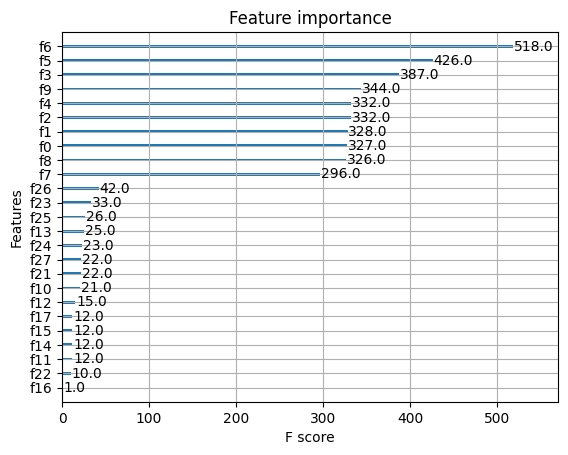

In [73]:
xgb.plot_importance(model)

In [74]:
yhat_probs = model.predict_proba(Xte, iteration_range=(0, model.best_iteration + 1))
yhat = model.predict(Xte, iteration_range=(0, model.best_iteration + 1))
yhat1_probs = yhat_probs[:, 1]

In [75]:
# with open(os.path.join(MODEL_DIR, 'xgb4_yhat_probs.pickle'), 'wb') as f:
#     pickle.dump(yhat_probs, f)
    
# with open(os.path.join(MODEL_DIR, 'xgb4_yhat.pickle'), 'wb') as f:
#     pickle.dump(yhat, f)

In [76]:
models.append('xgb')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## XGBoost (xgb2)
by Hao Ting

In [77]:
model = XGBClassifier()  # init model
model.load_model(os.path.join(MODEL_DIR, 'xgb5.model'))
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [ ]:
xgb.plot_importance(model)

In [79]:
## load data for xgb2
df_feature = pd.read_csv('../data/xgb2_feature.csv')
df_label = pd.read_csv('../data/xgb2_label.csv')
_, Xte2, _, yte2 = train_test_split(df_feature, df_label, test_size=0.2, random_state=42)

In [80]:
yhat_probs = model.predict_proba(Xte2, iteration_range=(0, model.best_iteration + 1))
yhat = model.predict(Xte2, iteration_range=(0, model.best_iteration + 1))
yhat1_probs = yhat_probs[:, 1]

In [81]:
models.append('xgb2')
roc_aucs.append(roc_auc_score(yte2, yhat1_probs))
pr_aucs.append(average_precision_score(yte2, yhat))
precisions.append(precision_score(yte2, yhat))
recalls.append(recall_score(yte2, yhat))
f1s.append(f1_score(yte2, yhat))
roc_curves.append(roc_curve(yte2, yhat1_probs))
pr_curves.append(precision_recall_curve(yte2, yhat1_probs))

## XGBoost (xgb3)
by Samuel

In [82]:
model = XGBClassifier()  # init model
model_dir = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/samueltjong/models')
model.load_model(os.path.join(model_dir, 'xgb6.model'))
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

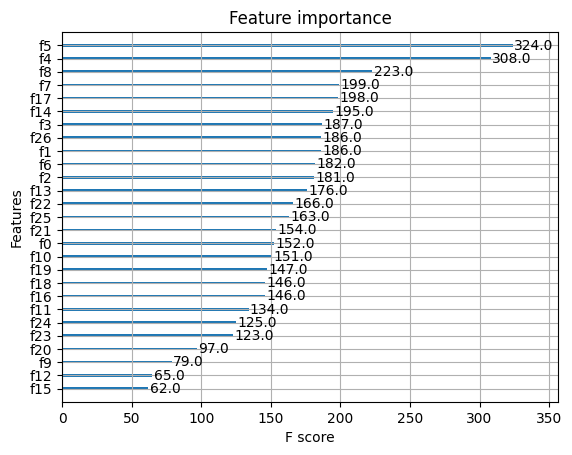

In [83]:
xgb.plot_importance(model)

In [84]:
## load data for xgb3
data_dir = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/samueltjong/data')
df_feature = pd.read_csv(os.path.join(data_dir, 'xgb3_feature.csv'))
df_label = pd.read_csv(os.path.join(data_dir, 'xgb3_label.csv'))
_, Xte3, _, yte3 = train_test_split(df_feature, df_label, test_size=0.2, random_state=42)

In [88]:
df_label.head()

,label
0,0
1,0
2,0
3,0
4,0


In [90]:
df_feature.shape

(121838, 27)

In [85]:
yhat_probs = model.predict_proba(Xte3, iteration_range=(0, model.best_iteration + 1))
yhat = model.predict(Xte3, iteration_range=(0, model.best_iteration + 1))
yhat1_probs = yhat_probs[:, 1]

In [86]:
models.append('xgb3')
roc_aucs.append(roc_auc_score(yte3, yhat1_probs))
pr_aucs.append(average_precision_score(yte3, yhat))
precisions.append(precision_score(yte3, yhat))
recalls.append(recall_score(yte3, yhat))
f1s.append(f1_score(yte3, yhat))
roc_curves.append(roc_curve(yte3, yhat1_probs))
pr_curves.append(precision_recall_curve(yte3, yhat1_probs))

## XGBoost (xgb4)
by Samuel

In [25]:
class SumRule:
  import numpy
  import scipy
  
  def __init__(self, model):
    self.model = model

  def sum_rule(self, y_instance_proba, pos_prior, neg_prior):
    n_instances = len(y_instance_proba)
    p_neg = (1 - n_instances) * (neg_prior) + self.numpy.sum(y_instance_proba[:, 0])
    p_pos = (1 - n_instances) * (pos_prior) + self.numpy.sum(y_instance_proba[:, 1])

    return self.scipy.special.softmax(self.numpy.array([p_neg, p_pos]) / (p_neg + p_pos))


  def predict(self, features, bag_indices, pos_prior=0.044936719250151844, neg_prior=0.9550632807498481):
    instance_proba = self.model.predict_proba(features)
    predictions = []

    for start, end in bag_indices:
      proba = self.sum_rule(instance_proba[start:end], pos_prior, neg_prior)
      predictions.append(int(proba[1] > proba[0]))

    return self.numpy.array(predictions)

  def predict_proba(self, features, bag_indices, pos_prior=0.044936719250151844, neg_prior=0.9550632807498481):
    instance_proba = self.model.predict_proba(features)
    bag_proba = []

    for start, end in bag_indices:
      proba = self.sum_rule(instance_proba[start:end], pos_prior, neg_prior)
      bag_proba.append(proba[1])

    return self.numpy.array(bag_proba)

In [26]:
import pandas as pd
import pickle
from xgboost import XGBClassifier

data_dir = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/samueltjong/data')
model_dir = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/samueltjong/models')
os.path.join(data_dir, 'bag_labels.pickle')
features = pd.read_csv(os.path.join(data_dir, 'sum_rule_feature.csv'))

with open(os.path.join(data_dir, 'bag_indices.pickle'), 'rb') as f:
  bag_indices = pickle.load(f)

with open(os.path.join(data_dir, 'bag_labels.pickle'), 'rb') as f:
  bag_labels = pickle.load(f)

model = XGBClassifier()
model.load_model(os.path.join(model_dir, 'sum_rule_xgb.model'))

In [32]:
sum_rule_model = SumRule(model)

yhat = sum_rule_model.predict(features, bag_indices)
yhat1_probs = sum_rule_model.predict_proba(features, bag_indices)

In [110]:
features.shape

(11027106, 9)

In [107]:
len(bag_labels)

121838

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

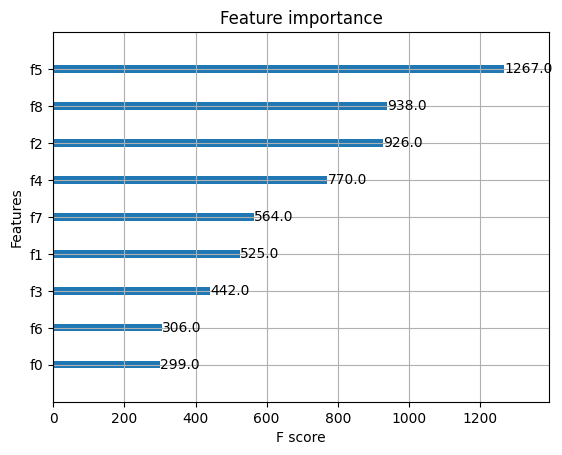

In [29]:
xgb.plot_importance(model)

In [34]:
models.append('xgb4')
roc_aucs.append(roc_auc_score(yte2, yhat1_probs))
pr_aucs.append(average_precision_score(yte2, yhat))
precisions.append(precision_score(yte2, yhat))
recalls.append(recall_score(yte2, yhat))
f1s.append(f1_score(yte2, yhat))
roc_curves.append(roc_curve(yte2, yhat1_probs))
pr_curves.append(precision_recall_curve(yte2, yhat1_probs))

NameError: name 'yte2' is not defined

## Evaluate models

nb: ROC AUC = 0.798
nb: PR AUC = 0.094
nb: Precision = 0.171
nb: Recall = 0.391
nb: F1 = 0.238
knn: ROC AUC = 0.753
knn: PR AUC = 0.165
knn: Precision = 0.493
knn: Recall = 0.268
knn: F1 = 0.347
lsvc: ROC AUC = 0.794
lsvc: PR AUC = 0.045
lsvc: Precision = 0.000
lsvc: Recall = 0.000
lsvc: F1 = 0.000
lda: ROC AUC = 0.842
lda: PR AUC = 0.213
lda: Precision = 0.491
lda: Recall = 0.378
lda: F1 = 0.427
qda: ROC AUC = 0.810
qda: PR AUC = 0.120
qda: Precision = 0.194
qda: Recall = 0.506
qda: F1 = 0.280
xgb: ROC AUC = 0.892
xgb: PR AUC = 0.194
xgb: Precision = 0.252
xgb: Recall = 0.720
xgb: F1 = 0.374
xgb2: ROC AUC = 0.828
xgb2: PR AUC = 0.110
xgb2: Precision = 0.142
xgb2: Recall = 0.668
xgb2: F1 = 0.235
xgb3: ROC AUC = 0.977
xgb3: PR AUC = 0.303
xgb3: Precision = 0.311
xgb3: Recall = 0.969
xgb3: F1 = 0.471


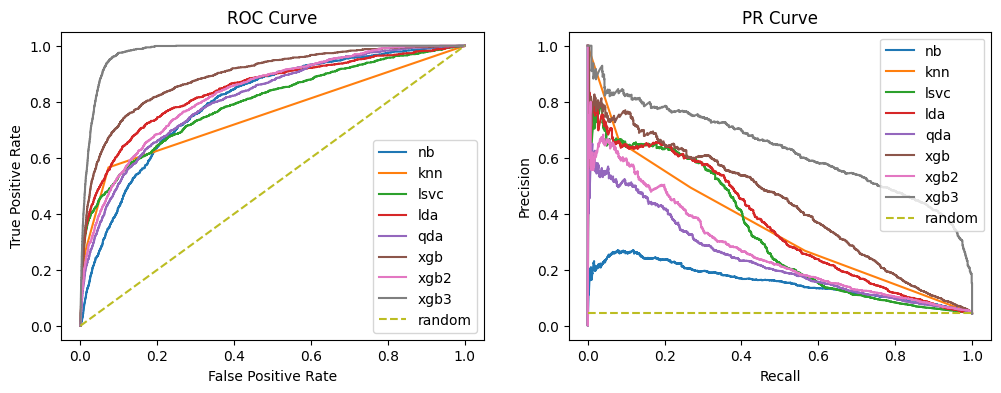

In [87]:
plt.figure(figsize=(12, 4))
random_yhat_probs = np.zeros(len(yte))
random_fpr, random_tpr, _ = roc_curve(yte, random_yhat_probs)

# relevant metrics
# roc_auc_score(yte, yhat1_probs)
# average_precision_score(yte, yhat)
# precision_score(yte, yhat)
# recall_score(yte, yhat)
# f1_score(yte, yhat)
# roc_curve(yte, yhat1_probs)
# precision_recall_curve(yte, yhat1_probs)

for _model, _roc_auc, _pr_auc, _precision, _recall, _f1, _roc_curve, _pr_curve in zip(models, roc_aucs, pr_aucs, precisions, recalls, f1s, roc_curves, pr_curves):
    print(f'{_model}: ROC AUC = {_roc_auc:.3f}')
    print(f'{_model}: PR AUC = {_pr_auc:.3f}')
    print(f'{_model}: Precision = {_precision:.3f}')
    print(f'{_model}: Recall = {_recall:.3f}')
    print(f'{_model}: F1 = {_f1:.3f}')


    # ROC
    fpr, tpr, _ = _roc_curve

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=_model)

    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # PR
    precision, recall, _ = _pr_curve

    plt.subplot(1, 2, 2)
    no_skill = len(yte[yte==1]) / len(yte)
    plt.plot(recall, precision, label=_model)

    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

plt.subplot(1, 2, 1)
plt.plot(random_fpr, random_tpr, linestyle='--', label='random')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='random')
plt.legend()
plt.show()